In [1]:
import heeps
from heeps.util.img_processing import resize_cube
from heeps.util.multiCPU import multiCPU
from heeps.util.coord import cart_coord
from astropy.io import fits
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Input parameters

In [2]:
npupil_L = 285              # L band
npupil_N = 119              # N2 band
nimg = 720
pupil_img_size = 39.9988
ax, ay = (-14.642, -55.812) # A0
bx, by = (  0.739, -75.899) # B2
cx, cy = (  5.691, -65.735) # C1
dx, dy = ( 15.628, -45.397) # D0
AT_rad = 1.8/2              # AT radius
AT_rot = -8.5               # AT rotation in deg
rms_L = 90
rms_N = 1000
dir_current = '/mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor'
wv = 'cube_Cbasic_%s_0piston_meters_scao_only_%s_WV.fits'
pup = fits.getdata(os.path.join(dir_current, 'mask_Cbasic_20210322_720.fits'))
pup[pup < .5] = np.nan

In [3]:
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])
def get_diff_piston(case, apers, xmax=300):
    filename = os.path.join(dir_current, wv%(case, nimg))
    savename = filename[:-5] + '_OPDs.fits'
    try:
        OPDs = fits.getdata(savename)
    except FileNotFoundError:
        pistons = np.empty((len(apers), len(fits.getdata(filename))))
        for i, aper in enumerate(apers):
            pistons[i,:] = multiCPU(get_piston, posvars=[aper*fits.getdata(filename)*1e9], case='get piston', verbose=True)
        OPDs = np.array([pistons[0,:] -  pistons[1,:],
                         pistons[0,:] -  pistons[2,:],
                         pistons[0,:] -  pistons[3,:],
                         pistons[1,:] -  pistons[2,:],
                         pistons[1,:] -  pistons[3,:],
                         pistons[2,:] -  pistons[3,:]])
        fits.writeto(savename, np.float32(OPDs), overwrite=True)
    plt.figure(figsize=(10, 5))
    for i, OPD in enumerate(OPDs):
        plt.plot(OPD, label='base %s'%(i+1))
    plt.xlim(0, xmax)
    plt.legend()
    plt.xlabel('Frames')
    plt.ylabel('Differential piston error (nm)')
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.savefig('diff_piston_%s.png'%case, dpi=300, transparent=True);
    return OPDs
def get_temporal_rms(OPDs, case, nframes=''):
    ncube = OPDs.shape[1]
    if nframes == '':
        nframes = OPDs.shape[1]
    temporal_rms = np.mean([np.mean(np.std(OPDs[:,i*nframes:(i+1)*nframes], 1)) for i in range(int(ncube/nframes))])
    print('mean temporal rms = %s nm'%np.round(temporal_rms, 2))
    return temporal_rms
def get_spatial_rms(temporal_rms, case, nframes='', xmax=300):
    savename = os.path.join(dir_current, wv%(case, npupil_L))[:-5] + 'Lonly%s.fits'%nframes
    try:
        cube_L = fits.getdata(savename)
    except FileNotFoundError:
        cube_L = rms_L/temporal_rms*resize_cube(fits.getdata(os.path.join(dir_current, wv%(case, nimg)))*1e9, npupil_L)
        fits.writeto(savename, np.float32(cube_L), overwrite=True)
    spatial_rms_L = np.mean(multiCPU(get_rms, posvars=[cube_L], case='get rms', verbose=False))
    print('L-band mean spatial rms = %s nm'%np.round(spatial_rms_L, 2))
    savename = os.path.join(dir_current, wv%(case, npupil_N))[:-5] + 'Nonly%s.fits'%nframes
    try:
        cube_N = fits.getdata(savename)
    except FileNotFoundError:
        cube_N = rms_N/temporal_rms*resize_cube(fits.getdata(os.path.join(dir_current, wv%(case, nimg)))*1e9, npupil_N)
        fits.writeto(savename, np.float32(cube_N), overwrite=True)
    spatial_rms_N = np.mean(multiCPU(get_rms, posvars=[cube_N], case='get rms', verbose=False))
    print('N-band mean spatial rms = %s nm'%np.round(spatial_rms_N, 2))

## AT coordinates

In [4]:
# find circumcenter and translate
d = 2 * (ax * (by - dy) + bx * (dy - ay) + dx * (ay - by))
ux = ((ax**2 + ay**2) * (by - dy) + (bx**2 + by**2) * (dy - ay) + (dx**2 + dy**2) * (ay - by)) / d
uy = ((ax**2 + ay**2) * (dx - bx) + (bx**2 + by**2) * (ax - dx) + (dx**2 + dy**2) * (bx - ax)) / d
ATs = np.array([[ax, ay], [bx, by], [cx, cy], [dx, dy]]) - [ux, uy]
# rotate to fit in ELT M1
t = np.deg2rad(AT_rot)
ATs = np.array([(x*np.cos(t) - y*np.sin(t), x*np.sin(t) + y*np.cos(t)) for x,y in ATs])
print('AT coords:\n%s'%ATs)

AT coords:
[[-17.19345442   4.94727687]
 [ -4.95044907 -17.19254133]
 [  1.44949234  -7.8721363 ]
 [ 14.28349078  10.77368621]]


## Create subapertures

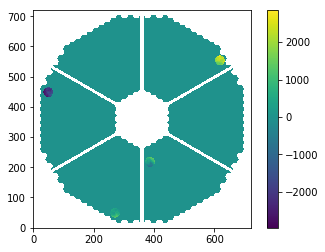

In [5]:
savename = os.path.join(dir_current, 'wv_apers.fits')
try:
    apers = fits.getdata(savename)
except FileNotFoundError:
    XY = np.array(cart_coord(nimg), ndmin=4)*pupil_img_size/2
    XY = (XY.T - ATs.T).T
    apers = np.abs(XY[:,0] + 1j*XY[:,1])
    apers = (apers <= AT_rad).astype(int)
    fits.writeto(savename, np.float32(apers), overwrite=True)
case = '20210322_600s_100ms'
frame = fits.getdata(os.path.join(dir_current, wv%(case, nimg)))[0]*1e9 # in nm
apers_ATs_phase = np.sum(apers, 0)*frame + pup
plt.imshow(apers_ATs_phase, origin=True), plt.colorbar();

## 1/ 40m outer scale, 600s, 100ms

mean temporal rms = 2414.06 nm
L-band mean spatial rms = 59.01 nm
N-band mean spatial rms = 622.0 nm


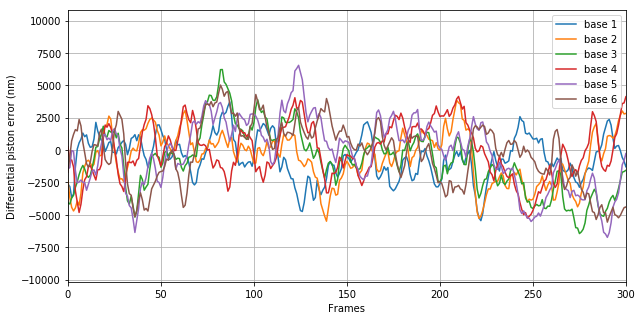

In [6]:
case = '20210322_600s_100ms'
OPDs = get_diff_piston(case, apers)
temporal_rms = get_temporal_rms(OPDs, case)
get_spatial_rms(temporal_rms, case)

### temporal RMS averraged over 1-minute sequences

In [7]:
temporal_rms = get_temporal_rms(OPDs, case, nframes=600)
get_spatial_rms(temporal_rms, case, nframes=600)

mean temporal rms = 2346.67 nm
L-band mean spatial rms = 60.71 nm
N-band mean spatial rms = 639.86 nm


## 2/ 500m outer scale, 600s, 100ms

mean temporal rms = 9924.83 nm
L-band mean spatial rms = 49.46 nm
N-band mean spatial rms = 523.73 nm


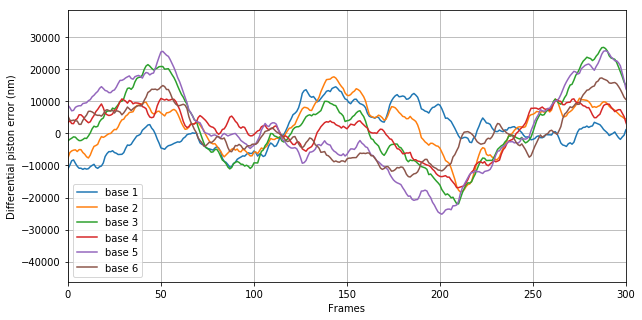

In [8]:
case = '20210504_600s_100ms'
OPDs = get_diff_piston(case, apers)
temporal_rms = get_temporal_rms(OPDs, case)
get_spatial_rms(temporal_rms, case)

### temporal RMS averraged over 1-minute sequences

In [9]:
temporal_rms = get_temporal_rms(OPDs, case, nframes=600)
get_spatial_rms(temporal_rms, case, nframes=600)

mean temporal rms = 8790.46 nm
L-band mean spatial rms = 55.84 nm
N-band mean spatial rms = 591.31 nm


## 3/ 500m outer scale, 3600s, 100ms

mean temporal rms = 10007.68 nm
L-band mean spatial rms = 47.75 nm
N-band mean spatial rms = 505.63 nm


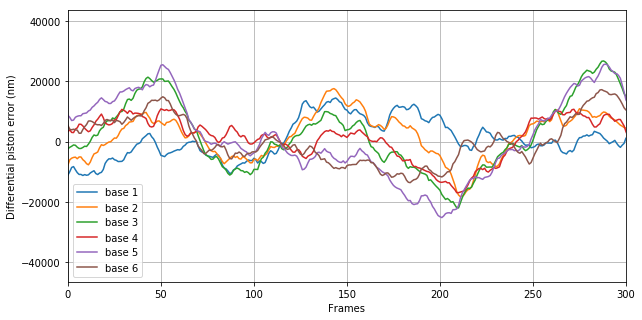

In [10]:
case = '20210601_3600s_100ms'
OPDs = get_diff_piston(case, apers)
temporal_rms = get_temporal_rms(OPDs, case)
get_spatial_rms(temporal_rms, case)

### temporal RMS averraged over 1-minute sequences

In [11]:
temporal_rms = get_temporal_rms(OPDs, case, nframes=600)
get_spatial_rms(temporal_rms, case, nframes=600)

mean temporal rms = 8814.1 nm
L-band mean spatial rms = 54.22 nm
N-band mean spatial rms = 574.1 nm


## 4/ 500m outer scale, 3600s, 300ms

mean temporal rms = 10008.57 nm
L-band mean spatial rms = 47.75 nm
N-band mean spatial rms = 505.59 nm


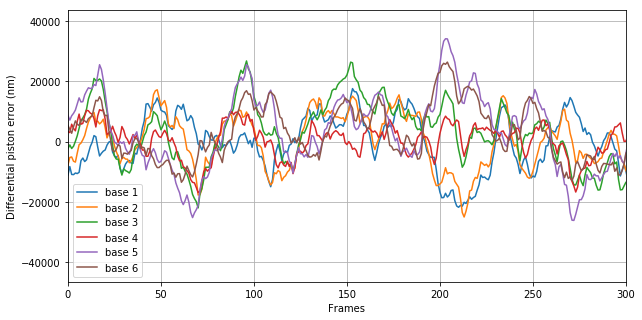

In [12]:
case = '20210601_3600s_300ms'
OPDs = get_diff_piston(case, apers)
temporal_rms = get_temporal_rms(OPDs, case)
get_spatial_rms(temporal_rms, case)

### temporal RMS averraged over 1-minute sequences

In [13]:
temporal_rms = get_temporal_rms(OPDs, case, nframes=200)
get_spatial_rms(temporal_rms, case, nframes=200)

mean temporal rms = 8814.11 nm
L-band mean spatial rms = 54.22 nm
N-band mean spatial rms = 574.11 nm
